In [64]:
import torch
from torch import nn
from typing import List
import torch.nn.functional as F
from transformers import AutoTokenizer, AutoModelWithLMHead
import pytorch_lightning as pl
from torch.utils.data import DataLoader, Dataset
import pandas as pd
from sklearn.metrics import classification_report
torch.__version__
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
from transformers import T5Tokenizer, T5ForConditionalGeneration

In [51]:
tokenizer = T5Tokenizer.from_pretrained("t5-base")
model = T5ForConditionalGeneration.from_pretrained("t5-base")

# tokenizer = AutoTokenizer.from_pretrained("mrm8488/t5-base-finetuned-emotion")
# model = AutoModelWithLMHead.from_pretrained("mrm8488/t5-base-finetuned-emotion")

In [52]:
def rank_nlp_dataset_final(dataset, tokenizer, model, prefix):

    from cleanlab.rank import get_label_quality_scores
    #### Run the model 

    def get_emotion_probs(text):
        with torch.no_grad():
            enc = tokenizer(prefix+text, return_tensors="pt", padding=True)

            decoder_input_ids = torch.tensor([tokenizer.pad_token_id]).unsqueeze(0)
            
            logits = model(**enc, decoder_input_ids=decoder_input_ids)[0]
#             tokens = torch.argmax(logits, dim=2)
#             emotion = tokenizer.batch_decode(tokens)
        return F.softmax(logits,dim=2).squeeze(0)
    
    ## Get pred probs
    pred_probs=[]
    given = []
    for idx in tqdm(range(len(dataset))):
        text,target_emo = dataset[idx]
        pred_probs.append(get_emotion_probs(text)[0])
        given.append(tokenizer.encode(target_emo)[:-1])

        
    ## Prep for cleanlab
    pred_probs = np.stack(pred_probs)
    given = np.array(given)
    
    ranked_label_issues = get_label_quality_scores(given, pred_probs)
    return ranked_label_issues

In [53]:
from datasets import load_dataset
dataset = load_dataset("xsum", "en")
# dataset = load_dataset("amazon_reviews_multi", "en")

  0%|          | 0/3 [00:00<?, ?it/s]

In [54]:
len(dataset['train'])

204045

In [55]:
# english_dataset = load_dataset("amazon_reviews_multi", "en")

In [56]:
dataset['train'][0]

{'document': 'The full cost of damage in Newton Stewart, one of the areas worst affected, is still being assessed.\nRepair work is ongoing in Hawick and many roads in Peeblesshire remain badly affected by standing water.\nTrains on the west coast mainline face disruption due to damage at the Lamington Viaduct.\nMany businesses and householders were affected by flooding in Newton Stewart after the River Cree overflowed into the town.\nFirst Minister Nicola Sturgeon visited the area to inspect the damage.\nThe waters breached a retaining wall, flooding many commercial properties on Victoria Street - the main shopping thoroughfare.\nJeanette Tate, who owns the Cinnamon Cafe which was badly affected, said she could not fault the multi-agency response once the flood hit.\nHowever, she said more preventative work could have been carried out to ensure the retaining wall did not fail.\n"It is difficult but I do think there is so much publicity for Dumfries and the Nith - and I totally apprecia

In [57]:
smaller_dataset ={}
# for i in tqdm(range(len(dataset['validation']))):
for i in tqdm(range(1000)):
    smaller_dataset[i] = ((dataset['validation'][i]["document"], dataset['validation'][i]["summary"]))

100%|██████████| 1000/1000 [00:00<00:00, 8602.68it/s]


In [58]:
rank3 = rank_nlp_dataset_final(smaller_dataset,tokenizer,model, "summarize:")

100%|██████████| 1000/1000 [04:20<00:00,  3.84it/s]
/datasets/vedang/jup_env/lib/python3.6/site-packages/ipykernel_launcher.py:28: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


In [59]:
np.argsort(rank3)

array([678, 713, 418, 328, 762, 789, 300, 190, 980, 533, 356, 834, 696,
       186, 978, 308, 700, 716, 411, 591, 795, 530, 736, 831, 799, 968,
       281, 475, 199,   0, 221, 742, 752, 246, 197, 882, 503, 905, 897,
       803, 663, 728, 777, 853, 559, 495, 837, 722, 573,  35,  56, 750,
       157, 680, 108, 705, 340,  84, 560, 929, 400, 216,  78, 830, 275,
       639,  96, 636, 619, 452, 753, 554, 931,  17, 285, 754, 415, 425,
       962, 144,  50, 920, 317, 323, 833, 571, 207, 369, 737, 990, 812,
       617, 249, 326, 720, 556, 350, 906, 928,  86, 115, 868, 172,  68,
       179,  10,  33,  22,  59, 431, 675, 610, 242, 642, 942, 188, 744,
       694, 672, 657, 231, 723, 952, 419, 765, 703, 846, 699,  39, 403,
       135, 870, 819, 702, 549, 843, 622, 151, 205, 582, 485, 844, 734,
       227, 828, 332,   4, 182, 141,  44, 299, 890, 447, 528, 544, 576,
       977, 907, 353, 981, 748, 858, 427, 838,  81, 240, 142, 210, 721,
       984,  52, 133, 140, 235, 867,  47, 816, 850, 365, 688, 10

In [49]:
smaller_dataset[0]

('The ex-Reading defender denied fraudulent trading charges relating to the Sodje Sports Foundation - a charity to raise money for Nigerian sport.\nMr Sodje, 37, is jointly charged with elder brothers Efe, 44, Bright, 50 and Stephen, 42.\nAppearing at the Old Bailey earlier, all four denied the offence.\nThe charge relates to offences which allegedly took place between 2008 and 2014.\nSam, from Kent, Efe and Bright, of Greater Manchester, and Stephen, from Bexley, are due to stand trial in July.\nThey were all released on bail.',
 'Former Premier League footballer Sam Sodje has appeared in court alongside three brothers accused of charity fraud.')

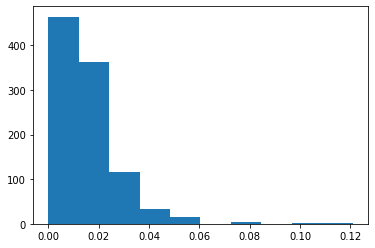

In [65]:
plt.hist(rank3)
plt.show()

In [66]:
from sklearn.metrics import precision_recall_curve, auc, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
def lift_at_k(y_true: np.array, y_score: np.array, k: int = 100) -> float:
    """Compute Lift at K evaluation metric"""

    # sort scores
    sort_indices = np.argsort(y_score)

    # compute lift for the top k values
    lift_at_k = y_true[sort_indices][-k:].mean() / y_true.mean()

    return lift_at_k

def compute_metrics(scores: np.array, true_error: np.array, metrics_metadata: dict={}, plot=True) -> dict:
    """
    Uses passed in `scores` of length (N,) and `true_error` mask of length (N,) to calculate metrics for the data.
    
    Parameters
    ----------
    scores : np.ndarray
      Scores per example with values [0,1]. Smaller values indicating examples that are more likeley to have error. 
      Can come directly from calclation like `scores = get_label_quality_scores()`.
    
    true_error : np.ndarray
      Binary mask indicating which examples have error with 1 = error and 0 = no error.
      
    metrics_metadata : dict
      Additional information to append to the calculated metrics dict.
      
    Returns
    -------
    metrics : dict
      A dictionary of computed metrics given `scores` and `true_error`. 
    """
    # compute precision-recall curve using quality scores
    precision, recall, thresholds = precision_recall_curve(true_error, 1 - scores)
    
    # compute prc auc scores
    auprc = auc(recall, precision)
    
    # compute accuracy of detecting errors
    auroc = roc_auc_score(true_error, 1 - scores)

    # lift at K where K = number of errors
    lift_at_num_errors = lift_at_k(true_error, 1 - scores, k=true_error.sum())

    # lift at k=100
    lift_at_100 = lift_at_k(true_error, 1 - scores, k=100)
    
    # feel free to add your own metrics
    metrics = {
        "dataset_num_samples": len(scores),
        "dataset_num_errors": true_error.sum(),
        "auroc": auroc,
        "auprc": auprc,
        "precision": precision,
        "recall": recall,
        "thresholds": thresholds,
        "lift_at_num_errors": lift_at_num_errors,
        "lift_at_100": lift_at_100,
    }
    
    if len(metrics_metadata) > 0:
        metrics = {**metrics_metadata, **metrics}
        
    if plot:
        fpr, tpr, _ = roc_curve(true_error, 1-scores) 
        fig1,(ax1, ax2) = plt.subplots(1,2, figsize=(10,5))
        ax1.plot(fpr, tpr)
        ax1.set_xlabel("False Positive Rate")
        ax1.set_ylabel("True Positive Rate")
        ax1.set_title(f"AUROC={auroc}")
        ax2.plot(recall, precision) 
        ax2.set_xlabel("Recall")
        ax2.set_title(f"AUPRC={auprc}")
        ax2.set_ylabel("Precision")
        plt.show()
        
    return metrics

In [72]:
dataset_indicies = np.where(rank3>0.01)[0]

In [74]:
len(dataset_indicies)

617

In [77]:
new_ts = np.array([smaller_dataset[idx][1] for idx in range(len(dataset_indicies))])

In [80]:
np.random.seed(seed=4)

has_error = []
new_dataset = {}
for idx in range(len(dataset_indicies)):
    source,target = smaller_dataset[idx]
    if np.random.random() >0.7:
        target = np.random.choice(new_ts, 1)[0]
        has_error.append(1)
    else:
        has_error.append(0)
    new_dataset[idx] = source, target
    
    

100%|██████████| 617/617 [02:41<00:00,  3.83it/s]
/datasets/vedang/jup_env/lib/python3.6/site-packages/ipykernel_launcher.py:28: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


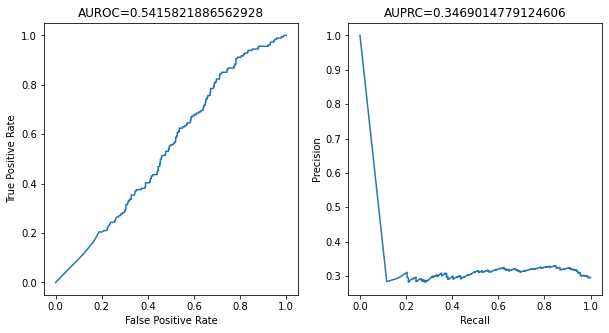

{'dataset_num_samples': 617,
 'dataset_num_errors': 181,
 'auroc': 0.5415821886562928,
 'auprc': 0.3469014779124606,
 'precision': array([0.29575163, 0.29459902, 0.29508197, 0.2955665 , 0.29605263,
        0.29654036, 0.29537954, 0.29586777, 0.29635762, 0.29684909,
        0.29734219, 0.29783694, 0.29833333, 0.29883139, 0.2993311 ,
        0.2998325 , 0.29865772, 0.29915966, 0.2996633 , 0.30016863,
        0.30067568, 0.29949239, 0.3       , 0.30050934, 0.29931973,
        0.29982964, 0.3003413 , 0.3008547 , 0.30136986, 0.30188679,
        0.3024055 , 0.30120482, 0.3       , 0.30051813, 0.30103806,
        0.30155979, 0.30208333, 0.30086957, 0.30139373, 0.30191972,
        0.30244755, 0.30297723, 0.30350877, 0.30404218, 0.30457746,
        0.30511464, 0.30565371, 0.30619469, 0.30673759, 0.30728242,
        0.30782918, 0.3083779 , 0.30892857, 0.30948122, 0.31003584,
        0.31059246, 0.30935252, 0.30990991, 0.30866426, 0.30922242,
        0.30978261, 0.31034483, 0.31090909, 0.31147541

In [81]:
rank_with_error = rank_nlp_dataset_final(new_dataset, tokenizer, model, "")

compute_metrics(rank_with_error,np.array(has_error))